# Testing bias metrics and mitigation algorithms on the Compas dataset

In [1]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from aif360.datasets import CompasDataset
from aif360.algorithms.preprocessing import Reweighing, DisparateImpactRemover
from utility import *
sns.set_theme(style='darkgrid')

## Dataset Description

COMPAS (Correctional Offender Management Profiling for Alternative Sanctions) is a popular commercial algorithm used by judges and parole officers for scoring criminal defendant’s likelihood of reoffending (recidivism). It has been shown that the algorithm is biased in favor of white defendants, and against black inmates, based on a 2 year follow up study (i.e who actually committed crimes or violent crimes after 2 years). The pattern of mistakes, as measured by precision/sensitivity is notable.

## Dataset fairness metrics definition

The group fairness metrics related to the dataset are defined as follows:

- **Disparate impact**

$$
\frac{Pr(Y=1|S=unprivileged)}{Pr(Y=1|S=privileged)}
$$

> If the value is less than 0.8 or more than 1.2 we say that there is a _disparate impact_ on data

- **Statistical parity**

$$
Pr(Y=1|S=unprivileged)-Pr(Y=1|S=privileged)
$$

## Classifier fairness metrics definition

The group fairness metrics related to the classifier are defined below:

- **Balanced Accuracy**

$$
\frac{TP + TN}{2}
$$

- **Statistical parity**

$$
Pr(\hat{Y}=1|S=unprivileged)-Pr(\hat{Y}=1|S=privileged)
$$

- **Disparate Impact**

$$
\frac{Pr(\hat{Y}=1|S=unprivileged)}{Pr(\hat{Y}=1|S=privileged)}
$$

>If the value is less than 0.8 or more than 1.2 we say that there is a _disparate impact_ on data
- **Average odds difference**

$$
\frac{[(FPR_{S=unpriv} - FPR_{S=priv})+(TPR_{S=unpriv} - TPR_{S=priv})]}{2}
$$
>A value of 0 means _equality of odds_

- **Equal opportunity difference**

$$
TPR_{S=unpriv} - TPR_{S=priv}
$$

- **Theil Index**

$$
\frac{1}{n}\sum_{i=1}^n\frac{b_{i}}{\mu}\ln(\frac{b_{i}}{\mu}) \\
\text{with: } b_i=\hat{y_i}-y_i+1 \text{ and $\mu$ is the mean of $b_i$ }
$$
>Individual index measuring the distance of each individual predicted y from his real value. A value of 0 means equality. 

## Bias mitigation algorithms

In the following we will test two preprocessing bias mitigation algorithms and we will compare the impact they have on the model accuracy. The algorithms that we will test are the following:

1. **Reweighing**
    
> Reweighing is a preprocessing technique that Weights the examples in each (group, label) combination differently to ensure fairness before classification

2. **Disparate Impact Remover**

> This algorithm changes the values of the unsensitive variables at different levels of repair. An higher level of repair removes the disparate impact but loweres the accuracy, while a low level of repair does not change the data. The values of the unsensitive attributes are changed s.t. the correlation between the variables and the sensitive attribute _S_ is removed while keeping the ranking of the items for the classifier.
>
> Following the pre processing procedure suggested by M. Feldman et al. in _"Certifying and removing disparate impact." ACM SIGKDD International Conference on Knowledge Discovery and Data Mining, 2015_, we first scale the values s.t. the minimum is 0 and the maximum is 1 and then remove the sensitive variable from the dataset before training the classifier. 

3. **Sampling**

> Sampling is a modified version of the Reweighing algorithm. First of all, it considered the groups made by each combinantion of the values of sensitive variables and labels. Then, for each group it computes his disparity ($\frac{size\_exp}{size\_obs}$) and samples each group untill this value becomes 1. The final dataset will be a dataset in which each group is balanced.

# Importing and exploring the dataset

In [2]:
compas = CompasDataset(features_to_drop=['age_cat'])

In [3]:
compas.protected_attribute_names

['sex', 'race']

In [4]:
compas.metadata['protected_attribute_maps']

[{0.0: 'Male', 1.0: 'Female'}, {1.0: 'Caucasian', 0.0: 'Not Caucasian'}]

In [5]:
compas.label_names

['two_year_recid']

In [6]:
compas.favorable_label

0.0

In [7]:
compas_df = compas.convert_to_dataframe()[0]

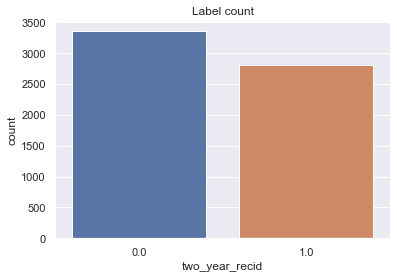

In [8]:
sns.countplot(x='two_year_recid', data=compas_df)
plt.title("Label count")
plt.show()

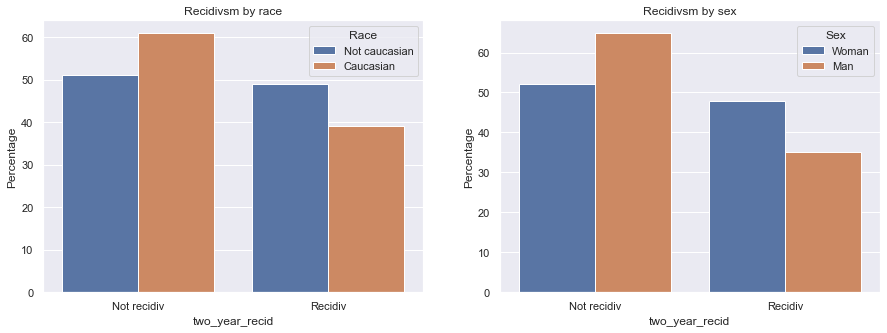

In [9]:
fig, [ax1, ax2] = plt.subplots(1,2,figsize=(15,5))
score_group = (compas_df.groupby(['race'])['two_year_recid']
              .value_counts(normalize=True).rename('Percentage').mul(100).reset_index())
score_group_sex = (compas_df.groupby(['sex'])['two_year_recid']
              .value_counts(normalize=True).rename('Percentage').mul(100).reset_index())
sns.barplot(data=score_group_sex, x='two_year_recid', y='Percentage', hue='sex', ax=ax2)
ax2.set_xticklabels({'Not recidiv', 'Recidiv'})
leg = ax2.legend()
leg.set_title('Sex')
leg.get_texts()[0].set_text('Woman')
leg.get_texts()[1].set_text('Man')
ax2.set_title('Recidivsm by sex')
sns.barplot(data=score_group, x='two_year_recid', y='Percentage', hue='race', ax=ax1)
ax1.set_xticklabels({'Not recidiv', 'Recidiv'})
leg = ax1.legend()
leg.set_title('Race')
leg.get_texts()[0].set_text('Not caucasian')
leg.get_texts()[1].set_text('Caucasian')
ax1.set_title('Recidivsm by race')
plt.show()

So we are in a **Balanced bias dataset** case

# Bias dataset and classification metrics

In [10]:
privileged_group = [{'sex':1, 'race':1}]
unprivileged_group = [{'sex':0, 'race':0}]

## Bias dataset case

### Dataset metrics

In [11]:
metrics = compute_dataset_fairness_metrics(compas, unprivileged_group, privileged_group)

Disparate Impact = 0.7480
Statistical Parity = -0.1627


### Classification metrics

Balanced accuracy: 0.6616
Statistical parity difference: -0.3928
Disparate impact: 0.5262
Average odds difference: -0.3628
Equal opportunity difference: -0.2949
Theil index: 0.2334


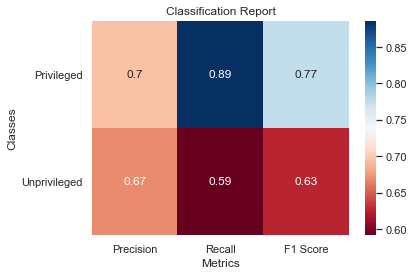

In [12]:
class_metrics = classify(
    make_pipeline(StandardScaler(), LogisticRegression(class_weight='balanced', solver='liblinear')), 
    compas, privileged_group, unprivileged_group)

## Reweighing

In [13]:
rw_data = compas.copy()
rw = Reweighing(unprivileged_group, privileged_group)
rw_data = rw.fit_transform(rw_data)

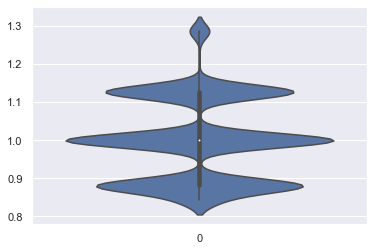

In [14]:
sns.violinplot(data=rw_data.instance_weights)
plt.show()

### Dataset metrics

In [15]:
metrics = compute_dataset_fairness_metrics(rw_data, unprivileged_group, privileged_group)

Disparate Impact = 1.0000
Statistical Parity = 0.0000


### Classification metrics

Balanced accuracy: 0.6507
Statistical parity difference: -0.1086
Disparate impact: 0.8473
Average odds difference: -0.1144
Equal opportunity difference: -0.0664
Theil index: 0.2078


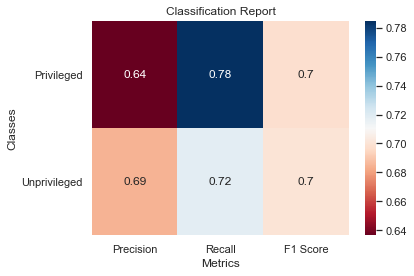

In [16]:
rw_class = classify(
    make_pipeline(StandardScaler(), LogisticRegression(class_weight='balanced', solver='liblinear')),
    rw_data, privileged_group, unprivileged_group)

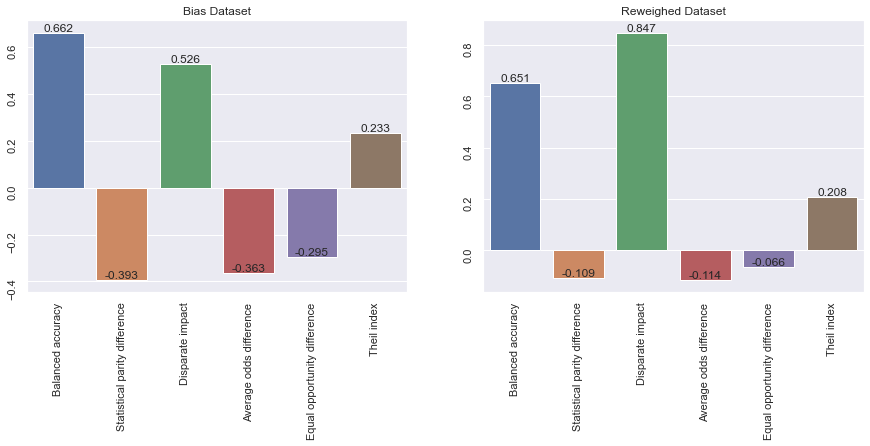

In [17]:
plot_metrics_comparison(class_metrics, rw_class, "Bias Dataset", "Reweighed Dataset")
plt.show()

## Disparate Impact

Since we have two sensitive attributes, DIR requires to create an attribute that is the joint probability distribution of the two sensitive attributes and to transform the unsensitive variables with respect to this new variable:

In [18]:
dir_data = compas.copy()
scaler = MinMaxScaler(copy=False)
dir_data.features = scaler.fit_transform(dir_data.features)

In [19]:
df = dir_data.convert_to_dataframe()[0]
probs = (
    df.value_counts(["sex", "race"], normalize=True).unstack().reset_index()
    .melt(id_vars='sex', value_vars=[0.0,1.0], var_name='race', value_name='probs'))

In [20]:
for sex,race,prob in probs.values:
    df.loc[(df['sex'] == sex) & (df['race'] == race), 'prob'] = prob

In [21]:
df.drop(df[['sex','race']], axis=1, inplace=True)

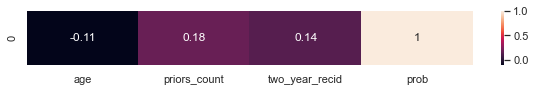

In [22]:
corr = df.corrwith(df['prob'], drop=True)
corr = pd.DataFrame(corr)
fig, ax = plt.subplots(1,1,figsize=(10,1))
sns.heatmap(corr[(abs(corr[0])>0.1)].T, annot=True)
plt.show()

In [23]:
probs

,sex,race,probs
0,0.0,0.0,0.547106
1,1.0,0.0,0.112372
2,0.0,1.0,0.262689
3,1.0,1.0,0.077834


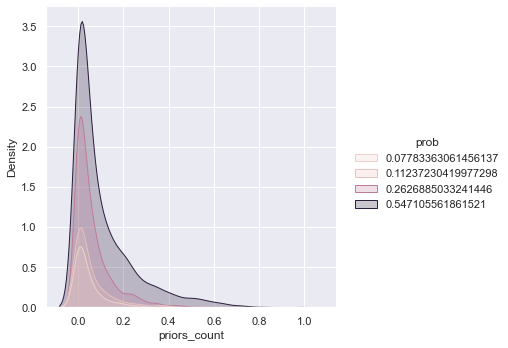

In [24]:
sns.displot(data=df, x='priors_count', hue='prob', kind='kde', multiple='layer', fill=True)
plt.show()

In [25]:
di = DisparateImpactRemover(sensitive_attribute='prob')
dir_data = BinaryLabelDataset(df=df, label_names=['two_year_recid'], protected_attribute_names=['prob'])
dir_data = di.fit_transform(dir_data)

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


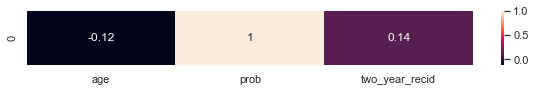

In [26]:
df_dir = dir_data.convert_to_dataframe()[0]
corr = df_dir.corrwith(df['prob'], drop=True)
corr = pd.DataFrame(corr)
fig, ax = plt.subplots(1,1,figsize=(10,1))
sns.heatmap(corr[(abs(corr[0])>0.1)].T, annot=True)
plt.show()

In [27]:
df.loc[df['prob'].round(6) == 0.077834, 'prob'] = 1
df.loc[df['prob'].round(6) != 1, 'prob'] = 0

df_dir.loc[df_dir['prob'].round(6) == 0.077834, 'prob'] = 1
df_dir.loc[df_dir['prob'].round(6) != 1, 'prob'] = 0

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


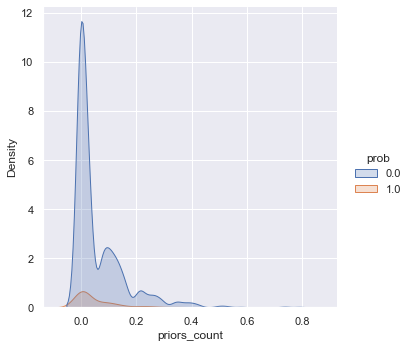

In [28]:
sns.displot(data=df_dir, x='priors_count', hue='prob', kind='kde', multiple='layer', fill=True)
plt.show()

### Dataset Metrics

In [29]:
prob_priv_group = [{'prob': 1}]
prob_unpriv_group = [{'prob': 0}]
dir_data = BinaryLabelDataset(df=df_dir, label_names=['two_year_recid'], protected_attribute_names=['prob'])

In [30]:
metrics = compute_dataset_fairness_metrics(dir_data, prob_unpriv_group, prob_priv_group)

Disparate Impact = 1.3102
Statistical Parity = 0.1099


Balanced accuracy: 0.6615
Statistical parity difference: 0.1146
Disparate impact: 1.3367
Average odds difference: 0.0777
Equal opportunity difference: 0.0708
Theil index: 0.2269


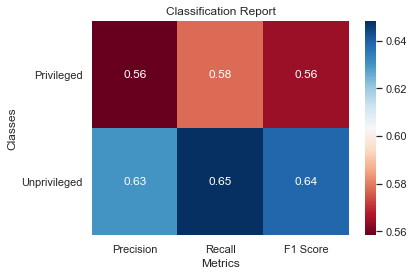

In [31]:
dir_class = classify(
    make_pipeline(StandardScaler(), LogisticRegression(class_weight='balanced', solver='liblinear')), 
    dir_data, priv_group = prob_priv_group, unpriv_group = prob_unpriv_group, sensitive_attributes=['prob'])

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


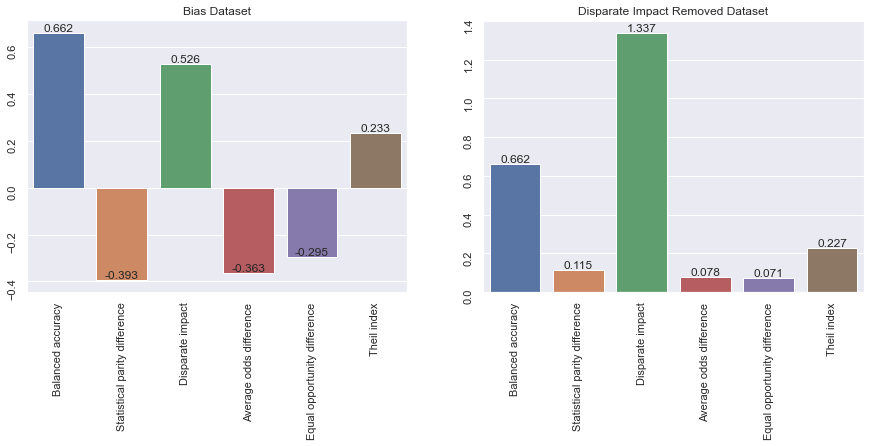

In [32]:
plot_metrics_comparison(class_metrics, dir_class, 'Bias Dataset', 'Disparate Impact Removed Dataset')
plt.show()

## Modified Reweighing (Sampling)

### Double sensitive attributes

Original dataset size: (6167,399)
Sampled dataset size: (6168,399)


Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


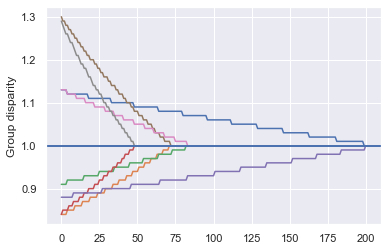

In [33]:
ps_df = compas_df.copy()
groups_conditions = [(ps_df['sex']==0)&(ps_df['race']==0),
    (ps_df['sex']==1)&(ps_df['race']==0), 
    (ps_df['sex']==0)&(ps_df['race']==1),
    (ps_df['sex']==1)&(ps_df['race']==1)]
sampled_data = sample_dataset(ps_df, groups_conditions, ps_df['two_year_recid']==0, 
                              ps_df['two_year_recid']==1, ['sex','race'], 'two_year_recid', round_level=2)
plt.show()

In [34]:
metrics = compute_dataset_fairness_metrics(sampled_data, unprivileged_group, privileged_group)

Disparate Impact = 1.0079
Statistical Parity = 0.0036


Balanced accuracy: 0.6573
Statistical parity difference: -0.0423
Disparate impact: 0.9349
Average odds difference: -0.0404
Equal opportunity difference: -0.0321
Theil index: 0.2321


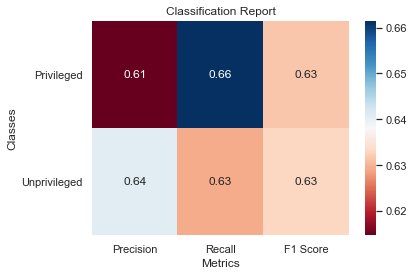

In [35]:
sampled_metrics = classify(
    make_pipeline(StandardScaler(), LogisticRegression(class_weight='balanced', solver='liblinear')), 
    sampled_data, privileged_group, unprivileged_group)

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


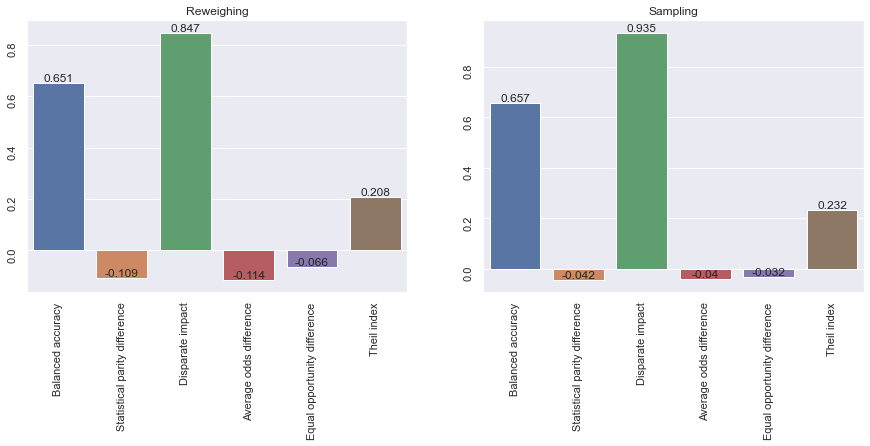

In [36]:
plot_metrics_comparison(rw_class, sampled_metrics, 'Reweighing', 'Sampling')
plt.show()

### Joint probability distribution

Original dataset size: (6167,398)
Sampled dataset size: (6165,398)


Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


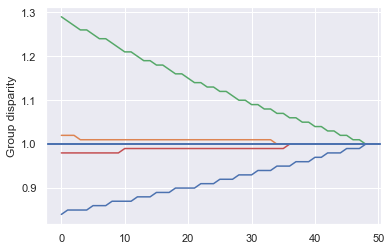

In [37]:
sampled_prob_data = sample_dataset(
    df, [df['prob']==1, df['prob']==0], 
    df['two_year_recid']==0, 
    df['two_year_recid']==1, 
    ['prob'], 'two_year_recid', round_level=2)
plt.show()

In [38]:
metrics = compute_dataset_fairness_metrics(sampled_prob_data, prob_unpriv_group, prob_priv_group)

Disparate Impact = 1.0082
Statistical Parity = 0.0037


Balanced accuracy: 0.6618
Statistical parity difference: -0.0305
Disparate impact: 0.9585
Average odds difference: -0.0328
Equal opportunity difference: -0.0358
Theil index: 0.2343


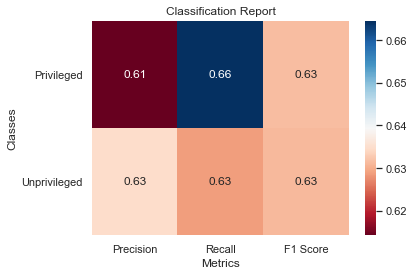

In [39]:
sampled_prob_metrics = classify(
    make_pipeline(StandardScaler(), LogisticRegression(class_weight='balanced', solver='liblinear')), 
    sampled_prob_data, prob_priv_group, prob_unpriv_group)

Compute the **Reweighing** with the joint probability and confront the results:

In [40]:
rw_prob_data = BinaryLabelDataset(df=df, label_names=['two_year_recid'], protected_attribute_names=['prob'])
rw = Reweighing(prob_unpriv_group, prob_priv_group)
rw_prob_data = rw.fit_transform(rw_prob_data)

Balanced accuracy: 0.6606
Statistical parity difference: -0.0225
Disparate impact: 0.9623
Average odds difference: -0.0211
Equal opportunity difference: -0.0102
Theil index: 0.2329


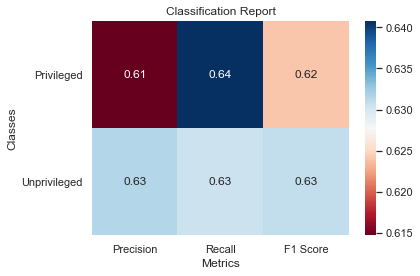

In [41]:
rw_prob_metrics = classify(make_pipeline(StandardScaler(), LogisticRegression(class_weight='balanced', solver='liblinear')), 
                           rw_prob_data, prob_priv_group, prob_unpriv_group)

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


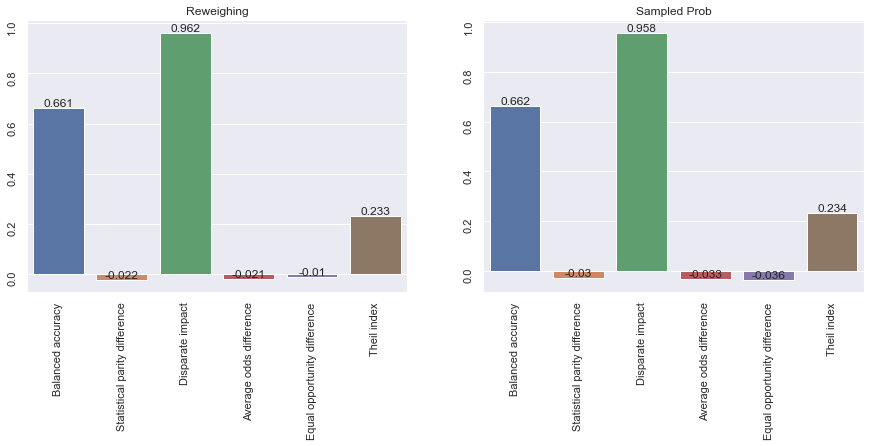

In [42]:
plot_metrics_comparison(rw_prob_metrics, sampled_prob_metrics, 'Reweighing', 'Sampled Prob')
plt.show()

## Reweighing + DIR

In [43]:
rw_dir_data = dir_data.copy()
rw = Reweighing(prob_unpriv_group, prob_priv_group)

In [44]:
rw_dir_data = rw.fit_transform(rw_dir_data)

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


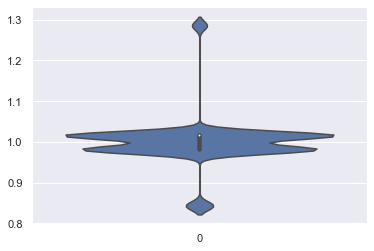

In [45]:
sns.violinplot(data= rw_dir_data.instance_weights)
plt.show()

### Dataset Metrics

In [46]:
metrics = compute_dataset_fairness_metrics(rw_dir_data, prob_unpriv_group, prob_priv_group)

Disparate Impact = 1.0000
Statistical Parity = 0.0000


### Classification Metrics

Balanced accuracy: 0.6593
Statistical parity difference: 0.0752
Disparate impact: 1.2391
Average odds difference: 0.0777
Equal opportunity difference: 0.0695
Theil index: 0.2263


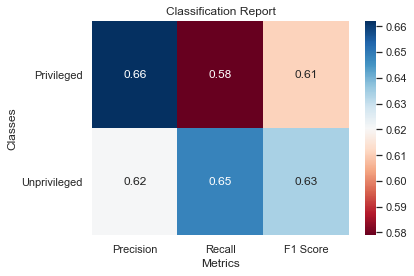

In [47]:
rw_dir_score = classify(
    make_pipeline(StandardScaler(), LogisticRegression(class_weight='balanced', solver='liblinear')),
    rw_dir_data, priv_group=prob_priv_group, unpriv_group=prob_unpriv_group, sensitive_attributes=rw_dir_data.protected_attribute_names)

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


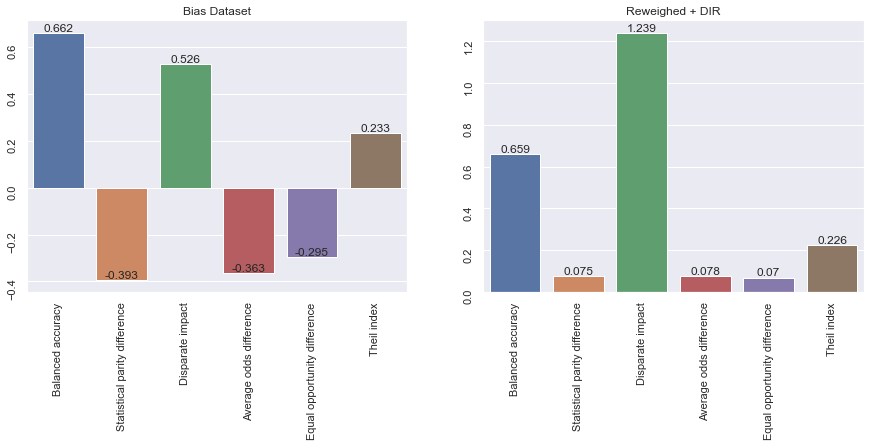

In [48]:
plot_metrics_comparison(class_metrics, rw_dir_score, 'Bias Dataset', 'Reweighed + DIR')
plt.show()

## Algorithms Comparison

metrics,Average odds difference,Balanced accuracy,Disparate impact,Equal opportunity difference,Statistical parity difference,Theil index
Dataset,,,,,,
Bias Dataset,-0.3628,0.6616,0.5262,-0.2949,-0.3928,0.2334
Disparate Impact Remover,0.0777,0.6615,1.3367,0.0708,0.1146,0.2269
Reweighing,-0.1144,0.6507,0.8473,-0.0664,-0.1086,0.2078
Reweighing + DIR,0.0777,0.6593,1.2391,0.0695,0.0752,0.2263
Reweighing Prob,-0.0211,0.6606,0.9623,-0.0102,-0.0225,0.2329
Sampling,-0.0404,0.6573,0.9349,-0.0321,-0.0423,0.2321
Sampling Prob,-0.0328,0.6618,0.9585,-0.0358,-0.0305,0.2343


Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


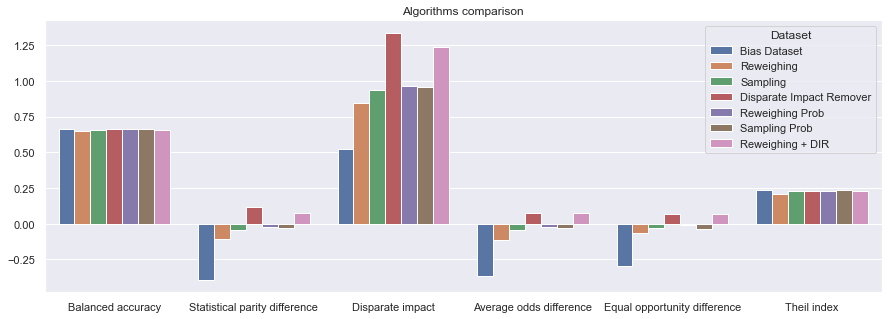

In [49]:
plot_syntesis(merge_datasets({
    'Bias Dataset': class_metrics,
    'Reweighing': rw_class,
    'Sampling': sampled_metrics,
    'Disparate Impact Remover': dir_class,
    'Reweighing Prob': rw_prob_metrics,
    'Sampling Prob': sampled_prob_metrics,
    'Reweighing + DIR': rw_dir_score
}), 'Algorithms comparison')
plt.show()